In [77]:
!pip install --quiet numpy pandas scikit-learn matplotlib pyarrow

In [79]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import RepeatedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, ElasticNetCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

RANDOM_STATE = 42
TOP_K = 25           # number of top features to display
STAB_B = 200         # bootstrap rounds for stability selection
STAB_SUBSAMPLE = 0.7 # fraction of rows per bootstrap
STAB_TAU = 0.6       # selection-frequency threshold for "signal"

# Paths
DATA_PATH_PARQUET = Path("/Users/cw/MATH 533 - Final Project/data/processed/riboflavin.parquet")
FIG_DIR  = Path("/Users/cw/MATH 533 - Final Project/results/Section1.2"); FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR  = Path("/Users/cw/MATH 533 - Final Project/results/Section1.2");  TAB_DIR.mkdir(parents=True, exist_ok=True)

In [81]:
# Load processed data
if DATA_PATH_PARQUET.exists():
    df = pd.read_parquet(DATA_PATH_PARQUET)
else:
    raise FileNotFoundError("No processed dataset found. Run 01_download_prepare.ipynb first.")

# Split X, y
y = df["target"].values
X = df.drop(columns=["target"]).values
feature_names = df.drop(columns=["target"]).columns.astype(str).to_numpy()

X.shape, y.shape

((71, 4088), (71,))

In [83]:
rng = np.random.RandomState(RANDOM_STATE)
sel_counts = np.zeros(X.shape[1], dtype=int)
alphas = np.logspace(-3, 0, 15)

for b in range(STAB_B):
    idx = rng.choice(len(y), int(STAB_SUBSAMPLE * len(y)), replace=False)
    scaler = StandardScaler(with_mean=True)
    Xb = scaler.fit_transform(X[idx])
    yb = y[idx]
    l1 = Lasso(alpha=np.median(alphas), max_iter=6000, random_state=rng.randint(1e9))
    l1.fit(Xb, yb)
    sel_counts += (np.abs(l1.coef_) > 1e-12)

sel_freq = sel_counts / STAB_B
consensus_mask = sel_freq >= STAB_TAU
consensus_idx = np.where(consensus_mask)[0]

# Keep top-K features by selection frequency
order = np.argsort(sel_freq[consensus_idx])[::-1] if len(consensus_idx) else np.array([], dtype=int)
feat_order = consensus_idx[order][:TOP_K] if len(consensus_idx) else np.array([], dtype=int)

print(f"Consensus features (≥{STAB_TAU:.0%} of bootstraps): {len(consensus_idx)}; displaying {len(feat_order)}")

Consensus features (≥60% of bootstraps): 9; displaying 9


In [85]:
# Define models
# Ridge
ridge = make_pipeline(
    StandardScaler(with_mean=True),
    RidgeCV(alphas=np.logspace(-3, 6, 25))
)

# Elastic Net
enet = make_pipeline(
    StandardScaler(with_mean=True),
    ElasticNetCV(l1_ratio=[.1,.3,.5,.7,.9,.95,.99,1.0],
                 alphas=np.logspace(-3, 2, 30),
                 max_iter=8000,
                 cv=5,
                 random_state=RANDOM_STATE)
)

def fit_bayesian_lasso_standardized(X, y):
    """
    Tries bayesreg (true Bayesian Lasso).
    Since bayesreg is unavailable, falls back to LassoCV (not Bayesian) so the notebook still runs.
    Returns (label, intercept, beta) on the ORIGINAL scale.
    """
    # Standardize once for the Bayesian fit (bayesreg standardizes internally, but we keep a scaler for fallback mapping)
    scaler = StandardScaler(with_mean=True).fit(X)
    Xs = scaler.transform(X)

    try:
        from bayesreg import bayesreg
        m = bayesreg(Xs, y, model='gaussian', method='blasso',
                     nsamples=4000, burnin=2000, thin=2, seed=RANDOM_STATE)
        beta_std = m['beta'].mean(axis=0)
        intercept_std = float(m['mu'].mean())
        # Map back to original scale
        beta = beta_std / (scaler.scale_ + 1e-12)
        intercept = intercept_std - (scaler.mean_ * beta).sum()
        label = "Bayesian Lasso (bayesreg)"
    except Exception as e:
        # Fallback: deterministic LassoCV
        pipe = make_pipeline(StandardScaler(with_mean=True),
                             LassoCV(alphas=np.logspace(-3,1,40), max_iter=8000, cv=5, random_state=RANDOM_STATE))
        pipe.fit(X, y)
        sc, lasso = pipe[0], pipe[1]
        beta = lasso.coef_ / (sc.scale_ + 1e-12)
        intercept = lasso.intercept_ - (sc.mean_ * beta).sum()
        label = "LassoCV"
    return label, intercept, beta

In [87]:
# Cross-validated performance & coefficient extraction (stable metrics)
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
scorers = {"rmse": "neg_root_mean_squared_error",  # built-in scorer
           "r2": "r2"}

def evaluate(est, name):
    # scores across all folds (no per-sample predictions)
    out = cross_validate(est, X, y, cv=cv, scoring=scorers, n_jobs=-1, return_estimator=False)
    rmse = -out["test_rmse"].mean()   # negate because we set greater_is_better=False
    r2   =  out["test_r2"].mean()

    # fit once on the full data to extract coefficients for plotting
    est.fit(X, y)
    sc, base = est[0], est[1]
    beta = base.coef_ / (sc.scale_ + 1e-12)
    intercept = base.intercept_ - (sc.mean_ * beta).sum()
    sparsity = int(np.sum(np.abs(beta) > 1e-12))
    return {"Method": name, "RMSE (CV)": rmse, "R² (CV)": r2, "Sparsity (#≠0)": sparsity}, (intercept, beta)

rows, coefs = [], {}

# Ridge
r_row, (r_int, r_beta) = evaluate(ridge, "RidgeCV")
rows.append(r_row); coefs["RidgeCV"] = (r_int, r_beta)

# Elastic Net
e_row, (e_int, e_beta) = evaluate(enet, "ElasticNetCV")
rows.append(e_row); coefs["ElasticNetCV"] = (e_int, e_beta)

# "Bayesian Lasso" (or fallback)
blabel, bl_int, bl_beta = fit_bayesian_lasso_standardized(X, y)
# If it fell back to LassoCV, compute CV metrics too; otherwise leave NaNs (true Bayesian can be slow to CV)
if "LassoCV" in blabel:
    from sklearn.pipeline import make_pipeline
    from sklearn.linear_model import LassoCV
    lasso_pipe = make_pipeline(
        StandardScaler(with_mean=True),
        LassoCV(alphas=np.logspace(-3,1,40), max_iter=8000, cv=5, random_state=RANDOM_STATE)
    )
    out = cross_validate(lasso_pipe, X, y, cv=cv, scoring=scorers, n_jobs=-1)
    rows.append({
        "Method": blabel,
        "RMSE (CV)": -out["test_rmse"].mean(),
        "R² (CV)":   out["test_r2"].mean(),
        "Sparsity (#≠0)": int(np.sum(np.abs(bl_beta) > 1e-12))
    })
else:
    rows.append({
        "Method": blabel,
        "RMSE (CV)": np.nan,
        "R² (CV)":   np.nan,
        "Sparsity (#≠0)": int(np.sum(np.abs(bl_beta) > 1e-12))
    })
coefs[blabel] = (bl_int, bl_beta)

leader = pd.DataFrame(rows).sort_values(by=["RMSE (CV)"], na_position="last")
leader

,Method,RMSE (CV),R² (CV),Sparsity (#≠0)
2,LassoCV,0.470744,0.702486,41
1,ElasticNetCV,0.490801,0.650208,161
0,RidgeCV,0.527197,0.610773,4088


In [88]:
# Save Leaderboard
leader_file = TAB_DIR / "leaderboard.csv"
leader.to_csv(leader_file, index=False)
leader_file.resolve()

PosixPath('/Users/cw/MATH 533 - Final Project/results/Section1.2/leaderboard.csv')

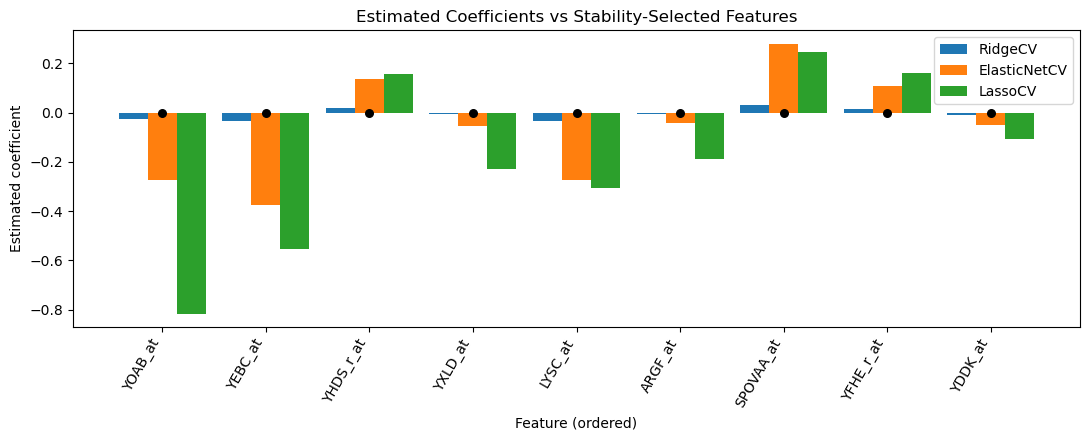

PosixPath('/Users/cw/MATH 533 - Final Project/results/Section1.2/coefficients_vs_stability.png')

In [89]:
# Plot
if len(feat_order) == 0:
    # If stability selection found no strong signals, fall back to top |beta| from ENet
    _, beta_ref = coefs["ElasticNetCV"]
    feat_order = np.argsort(np.abs(beta_ref))[::-1][:TOP_K]

ticks = np.arange(len(feat_order))

plt.figure(figsize=(11,4.5))
bar_width = 0.28
for j, name in enumerate(coefs.keys()):
    _, beta = coefs[name]
    plt.bar(ticks + (j - 1)*bar_width, beta[feat_order], width=bar_width, label=name)

# Black dots for stability-selected “true-ish” features
for k, idx in enumerate(feat_order):
    if consensus_mask[idx]:
        plt.scatter(k, 0, marker='o', s=30, color='black')  # black dot at baseline

plt.xticks(ticks, feature_names[feat_order], rotation=60, ha='right')
plt.xlabel("Feature (ordered)"); plt.ylabel("Estimated coefficient")
plt.title("Estimated Coefficients vs Stability-Selected Features")
plt.legend()
plt.tight_layout()

fig_path = FIG_DIR / "coefficients_vs_stability.png"
plt.savefig(fig_path, dpi=160)
plt.show()
fig_path.resolve()